In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy
from collections import defaultdict, Counter
import datetime


In [2]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/f/dev/git/miRExplore/python/nbs
['/mnt/f/dev/git/miRExplore/python', '/mnt/f/dev/git/miRExplore/python/nbs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython']


In [3]:
from textdb.PubmedDateDB import PubmedDateDB
from synonymes.mirnaID import miRNA, miRNAPART
from textdb.MiGenRelDB import MiGenRelDB

In [ ]:
allDatesFile = "/mnt/d/dev/data/pmid_jun2020/aggregated_pmid/allpmids.date"
dateDB = PubmedDateDB.loadFromFile(allDatesFile)

In [ ]:
len(sentDB.docid2date)

In [ ]:
sentDB.get_document("31378854")

In [ ]:
ym2pmids = defaultdict(set)
for x in sentDB.docid2date:
    ddate = list(sentDB.docid2date[x])
    
    if ddate[0] == 0:
        continue
        
    if ddate[1] == 0:
        ddate[1] = 1
    ddate[2] = 1
    
    try:
        ym2pmids[datetime.datetime.strptime("{}-{}-{}".format(*ddate), '%Y-%m-%d')].add(x)
    except:
        print(ddate)
        break

In [ ]:
ym2counts = Counter()
for date in ym2pmids:
    ym2counts[date] += len(ym2pmids[date])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()

def plotDateCounts(xdates, ydata, fname=None):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(figsize=(12,6))
    """
    xdatesTS = [datetime.datetime.timestamp(x) for x in xdates]
    allyears = sorted(set([int(x.year) for x in xdates]))
    
    minYearNum = min(allyears)
    maxYearNum = max(allyears)
    
    minYear = datetime.datetime.strptime("{}-1-1".format(minYearNum), '%Y-%m-%d')
    maxYear = datetime.datetime.strptime("{}-12-31".format(maxYearNum), '%Y-%m-%d')
    
    betweenTicks = []
    for i in range(minYear.year+1, maxYear.year+1):
        betweenTicks.append(
            datetime.datetime.strptime("{}-1-1".format(i), '%Y-%m-%d')
        )
        
    allticks = [minYear] + betweenTicks + [maxYear]
    """
    sns.scatterplot(x=xdates, y=ydata, ax=ax)
    

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    ax.set_xlim(min(xdates), max(xdates))
    #ax.set_xticks([datetime.datetime.timestamp(x) for x in allticks])
    #xticks = ax.get_xticks()
    #xticks_dates=[datetime.datetime.fromtimestamp(x).strftime('%Y-%m') for x in xticks]
    #ax.set_xticklabels(xticks_dates)
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    #ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)
    

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    #fig.autofmt_xdate()
    plt.xticks(rotation=90, ha="center")

    if fname != None:
        plt.savefig(fname)
    plt.show()

In [ ]:
xdates = sorted([x for x in ym2counts])
xdates = [x for x in xdates if x.year >= 1980]
ydata = [ym2counts[x] for x in xdates]

plotDateCounts(xdates, ydata)

In [ ]:
sum([ym2counts[x] for x in ym2counts])

In [ ]:
from utils.tmutils import normalize_gene_names
normGeneSymbols = normalize_gene_names(path="/mnt/d/owncloud/data/miRExplore/obodir/" + "/hgnc_no_withdrawn.syn")

In [ ]:
pmidBase ="/mnt/d/dev/data/pmid_jun2020/aggregated_pmid/"

print("Loading hsa")
mirelPMIDhsa = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.hsa.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)
print("Loading mmu")
mirelPMIDmmu = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.mmu.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)

relDBs = [mirelPMIDhsa, mirelPMIDmmu]

In [ ]:
miRNAGenePMIDs = set()
for rdb in relDBs:
    for rpmid in rdb.get_evidence_docids():
        miRNAGenePMIDs.add(rpmid)

In [ ]:
ym2InteractionCounts = Counter()
countsperYear = Counter()
totalPMIDs = 0
for date in ym2pmids:
    intersectPMIDs = len(miRNAGenePMIDs.intersection(ym2pmids[date]))
    ym2InteractionCounts[date] += intersectPMIDs
    totalPMIDs += intersectPMIDs
    countsperYear[date.year] += intersectPMIDs
    
print(totalPMIDs)

In [ ]:
sum([ym2InteractionCounts[x] for x in ym2InteractionCounts])

In [ ]:
for x in sorted(countsperYear):
    if x < 1980:
        continue
    
    print(x, countsperYear[x])

In [ ]:
sDates = sorted([d for d in ym2InteractionCounts])

sDates[:5]+sDates[-5:]

In [ ]:
xdates = sorted([x for x in ym2InteractionCounts])
xdates = [x for x in xdates if x.year >= 2005 and x.year < 2021]
ydata = [ym2InteractionCounts[x] for x in xdates]

ycumdata = [ydata[0]]
for i in range(1, len(ydata)):
    cumCount = ycumdata[-1] + ydata[i]
    ycumdata.append(cumCount)

print(xdates[:5]+xdates[-5:])
plotDateCounts(xdates, ycumdata, "pubmed_mirna_gene.png")


In [ ]:
len(ycumdata)

In [4]:
import requests, json
from synonymes.GeneOntology import GeneOntology
from collections import Counter


In [5]:
requestDict = {"gene": ["CCL2"], "sentences": "true"}

r = requests.post("http://localhost:65500/find_interactions", data=json.dumps(requestDict))
jsonRes = r.json()

In [ ]:
for x in jsonRes["pmidinfo"]:
    print(x, jsonRes["pmidinfo"][x].get("31875973", None))

In [57]:
for x in jsonRes['rels']:
    for y in x["evidences"]:
        
        docID = y.get("docid", None)
        docDate = y.get("docdate", None)
        
        print(y)

{'cellline': '1386LN', 'data_id': 101088, 'data_source': 'DIANA', 'direction': 'NA', 'lid': 'CCL2', 'lontid': 'CCL2', 'ltype': 'gene', 'measure': 'INDIRECT', 'method': 'Microarrays', 'orgs': ['hsa'], 'rid': 'miR-100-5p', 'rontid': 'miR-100-5p', 'rtype': 'mirna', 'tissue': 'Head/Neck'}
{'cellline': '4T1', 'data_id': 101089, 'data_source': 'DIANA', 'direction': 'DOWN', 'lid': 'CCL2', 'lontid': 'CCL2', 'ltype': 'gene', 'measure': 'INDIRECT', 'method': 'Microarrays', 'orgs': ['hsa'], 'rid': 'miR-100-5p', 'rontid': 'miR-100-5p', 'rtype': 'mirna', 'tissue': 'Mammary Gland'}
{'cellline': 'HACAT', 'data_id': 101090, 'data_source': 'DIANA', 'direction': 'DOWN', 'lid': 'CCL2', 'lontid': 'CCL2', 'ltype': 'gene', 'measure': 'INDIRECT', 'method': 'Microarrays', 'orgs': ['hsa'], 'rid': 'miR-100-5p', 'rontid': 'miR-100-5p', 'rtype': 'mirna', 'tissue': 'Skin'}
{'cellline': 'SCC29', 'data_id': 101091, 'data_source': 'DIANA', 'direction': 'NA', 'lid': 'CCL2', 'lontid': 'CCL2', 'ltype': 'gene', 'measure'

In [6]:
diseaseObo = GeneOntology("/mnt/f/dev/data/pmid_jun2020/obodir/" + "/doid.obo")
cellObo = GeneOntology("/mnt/f/dev/data/pmid_jun2020/obodir/" + "/meta_cells.obo")

infodict2obo = {}
infodict2obo["cells"] = cellObo
infodict2obo["disease"] = diseaseObo

0
10000
no parent 2382
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
no parent 43429


In [7]:
def getPMIDInfo(jsonRes, infodict, pmid):
    
    diseaseInfos = jsonRes["pmidinfo"][infodict].get(pmid, [])
    diseaseInfo = ""
        
    infoObo = infodict2obo.get(infodict, None)
    
    ignoreTerms = None
    if infodict == "cells":
        ignoreTerms = []
        
        for ignoreTerm in ["META:3", "META:707", "EFO:0000408", "META:403", "EFO:0000408", "BFO:0000017"]:
            ignoreTerms += [x.termid for x in infoObo[ignoreTerm].getAllChildren()]

    allFoundTerms = set()
    termid2termname = {}
    allDiseaseInfos = Counter()
    for di in diseaseInfos:
        dit = di.get("termname", None)
        diid = di.get("termid", None)
        
        #print(di["termid"], dit)
        
        if dit in ["cell", "cells", "protein", "data item", "role", "signaling", "immune response"]:
            continue
            
        if infodict == "cells" and diid != None and diid.startswith(("CHEBI", "PR", "DOID", "UBERON", "IAO")):
            continue
        
        if diid != None:
            allFoundTerms.add(diid)
            termid2termname[diid] = dit
            
        
        for diid in allFoundTerms:
            
            if infoObo != None:
                oboterm = infodict2obo[infodict][diid]
                
                if oboterm != None:
                    allchildren = [x.termid for x in oboterm.getAllChildren()]
                    allparents = [x.id for x in oboterm.getAllParents()]
                    
                    childIntersect = set(allchildren).intersection(allFoundTerms)
                    parentIntersect = set(allparents).intersection(allFoundTerms)

                    if (len(parentIntersect)>0) or (ignoreTerms != None and diid in ignoreTerms):
                        
                        igTerm = ignoreTerms != None and diid in ignoreTerms
                        
                        #print("skipping", diid, termid2termname[diid], len(parentIntersect), igTerm)
                        continue
                        
                    if len(childIntersect)> 0:
                        for x in childIntersect:
                            
                            if termid2termname[x] in allDiseaseInfos:
                                del allDiseaseInfos[termid2termname[x]]
                            #print("removing", termid2termname[x])
                        
        
            dit = termid2termname[diid]
            allFoundTerms.add(diid)
            
            allDiseaseInfos[dit] += 1

    allDiseaseInfos = [x[0] for x in allDiseaseInfos.most_common(4)]
    
    diseaseInfo = ""
    xlen = 20
    for xi, x in enumerate(allDiseaseInfos):
        

        
        if len(diseaseInfo) + len(x) > xlen:
            if xi > 0:
                diseaseInfo += ";"
            
            diseaseInfo += "\n" + x
            
            xlen += 20
                        
                
        else:
            if xi > 0:
                diseaseInfo += "; "
                
            diseaseInfo += x
            
            
                
    return diseaseInfo
    
getPMIDInfo(jsonRes, "disease", "29477204")

''

In [ ]:
oboterm = infodict2obo["cells"]["IAO:0000027"]
oboterm.getAllParents()

In [ ]:
EFO:0001073 obesity
CL:0009002 inflammatory cell
BFO:0000023 role
IAO:0000027 data item

In [ ]:
oboterm = infodict2obo["cells"]["META:2000"]
oboterm.getAllChildren()

In [ ]:
#infodict2obo["cells"]["META:5"].getAllChildren()

In [18]:
int2pubdate = defaultdict(set)

for x in jsonRes['rels']:
    for y in x["evidences"]:
        
        docID = y.get("docid", None)
        docDate = y.get("docdate", None)
        
        if docID == None or docDate == None:
            continue
        
        gene = y.get("lid", None)
        mirStr = y.get("rid", None)
        
        mirObj = miRNA(mirStr)
        
        diseaseInfo = getPMIDInfo(jsonRes, "disease", docID)
        cellInfo = getPMIDInfo(jsonRes, "cells", docID)
        goInfo = getPMIDInfo(jsonRes, "go", docID)
            
        
        int2pubdate[(gene, mirStr)].add((docID, docDate, diseaseInfo, cellInfo, goInfo))
        
        print(gene, mirObj, docID, docDate)

CCL2 miR-1-3p 18668037 1217368800.0
CCL2 miR-24-3p 19748357 1252620000.0
CCL2 miR-26b-5p 19088304 1229382000.0
CCL2 miR-155-5p 18668040 1217368800.0
CCL2 miR-124a 19404929 1241128800.0
CCL2 miR-124-3p 19404929 1241128800.0
CCL2 miR-124-3p 24122720 1381442400.0
CCL2 miR-132 19819989 1255039200.0
CCL2 miR-132 22431733 1332111600.0
CCL2 miR-132 22431733 1332111600.0
CCL2 miR-132 31408236 1565647200.0
CCL2 miR-10a 20624982 1278885600.0
CCL2 miR-10a 20624982 1278885600.0
CCL2 miR-146a 21329689 1297724400.0
CCL2 miR-146a 25646371 1422831600.0
CCL2 miR-146a 25646371 1422831600.0
CCL2 miR-146a 26541434 1446678000.0
CCL2 miR-146a 26852168 1447196400.0
CCL2 miR-146a 26902276 1454281200.0
CCL2 miR-146a 26902276 1454281200.0
CCL2 miR-146a 26902276 1454281200.0
CCL2 miR-146a 26902276 1454281200.0
CCL2 miR-146a 27913625 1480633200.0
CCL2 miR-146a 27913625 1480633200.0
CCL2 miR-146a 27913625 1480633200.0
CCL2 miR-146a 30103197 1538344800.0
CCL2 miR-146a 30103197 1538344800.0
CCL2 miR-21 21636785 1306

In [19]:
for x in int2pubdate:
    
    if len(int2pubdate[x]) > 1:
        
        print(x, len(int2pubdate[x]), int2pubdate[x])

('CCL2', 'miR-124-3p') 2 {('24122720', 1381442400.0, 'hypertension', 'fibroblast; monocyte', '\nfibroblast proliferation'), ('19404929', 1241128800.0, '', '', '')}
('CCL2', 'miR-132') 3 {('22431733', 1332111600.0, '', 'organ; aorta;\np120 cell;\nvascular associated smooth muscle cell', "phosphorylation;\ncell cycle;\nRNA-directed 5'-3' RNA polymerase activity;\ncAMP response element binding"), ('31408236', 1565647200.0, 'disease', "glial cell;\nAmmon's horn", 'extracellular matrix;\ninterleukin-1 receptor binding'), ('19819989', 1255039200.0, 'obesity', 'fat cell;\nadipose tissue; stem cell;\npreadipocyte', 'chemokine production;\ninterleukin-8 receptor binding')}
('CCL2', 'miR-146a') 7 {('27913625', 1480633200.0, 'kidney disease', '\nglomerular visceral epithelial cell;\nmonocyte', '\nepidermal growth factor-activated receptor activity;\nnegative regulation of kinase activity'), ('30103197', 1538344800.0, '', 'organ; AST; ALT;\nmacrophage', '\ninterleukin-6 receptor binding;\nL-alanin

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [54]:
def make_timeline( allInteractions, title ):

    allInteractions = sorted(allInteractions, key=lambda x: x[1])
    
    names = []
    dates = []

    for x in allInteractions:
        pmid = x[0] + "\n" + x[2] + "\n" + x[3] + "\n" + x[4]
        date = datetime.datetime.fromtimestamp(x[1])

        names.append(pmid)
        dates.append(date)
        
    alllevels = [-5,5,-3,3,-1,1]
        
    # Choose some nice levels
    levels = np.tile(alllevels,
                     int(np.ceil(len(dates)/len(alllevels))))[:len(dates)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(11, 10), constrained_layout=True)
    ax.set(title=title)

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, ltext, va in zip(dates, levels, names, vert):
        ax.annotate(ltext, xy=(d, l+ (-1) * np.sign(l) * 0.75), xytext=(-10, np.sign(l)*3),
                    textcoords="offset points", va=va, ha="right")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

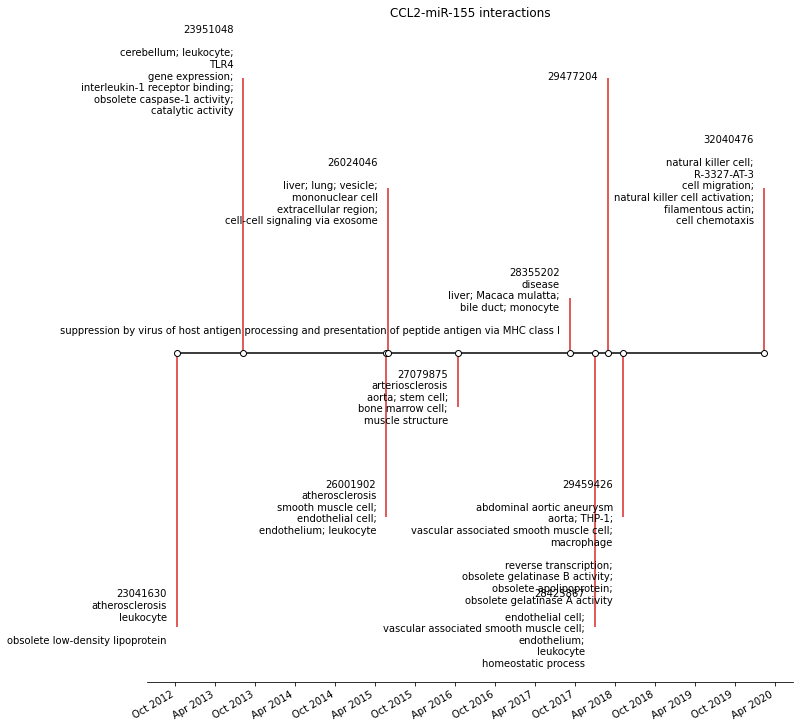

In [55]:
make_timeline(int2pubdate[('CCL2', 'miR-155')], "CCL2-miR-155 interactions") 

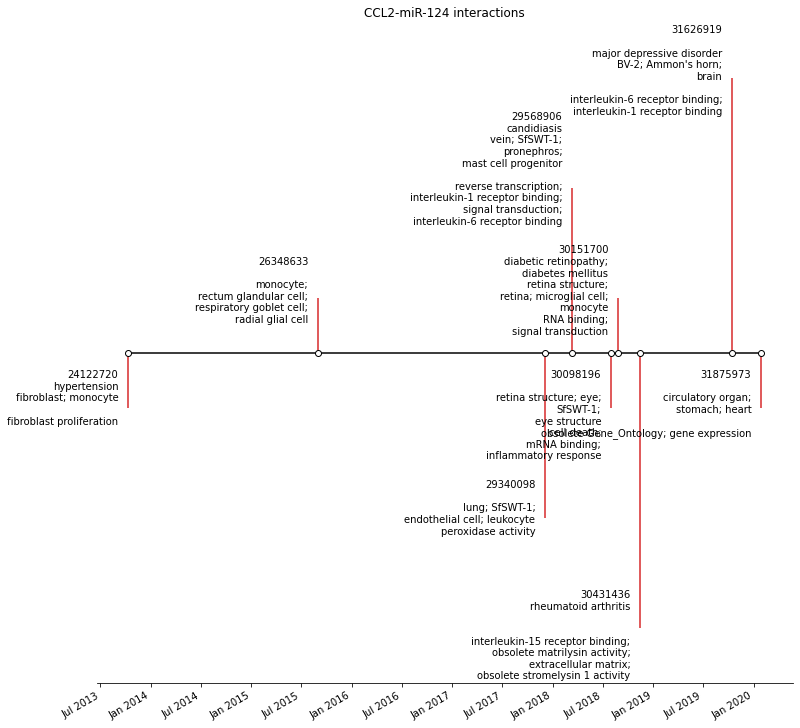

In [52]:
make_timeline(int2pubdate[('CCL2', 'miR-124')], "CCL2-miR-124 interactions") 

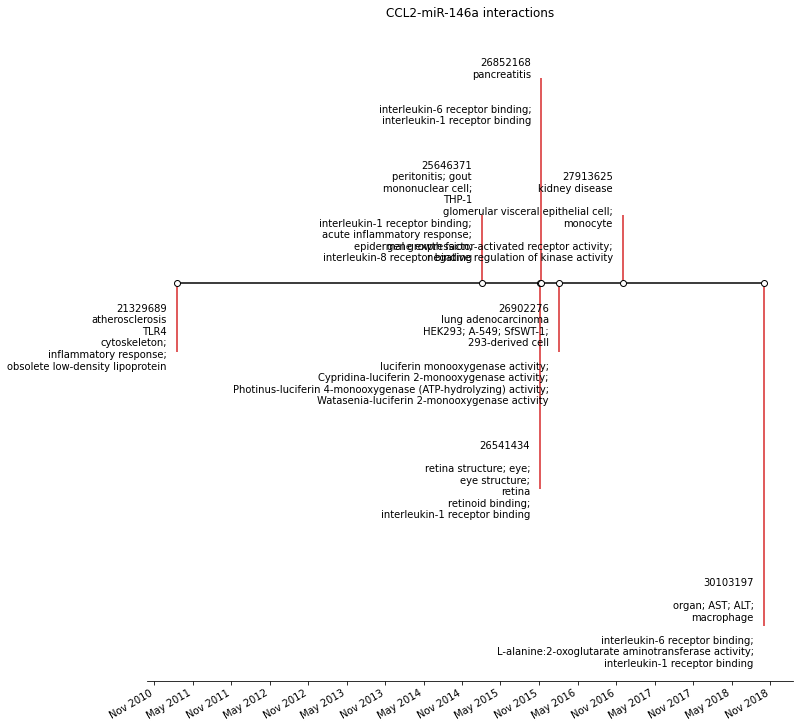

In [53]:
make_timeline(int2pubdate[('CCL2', 'miR-146a')], "CCL2-miR-146a interactions") 

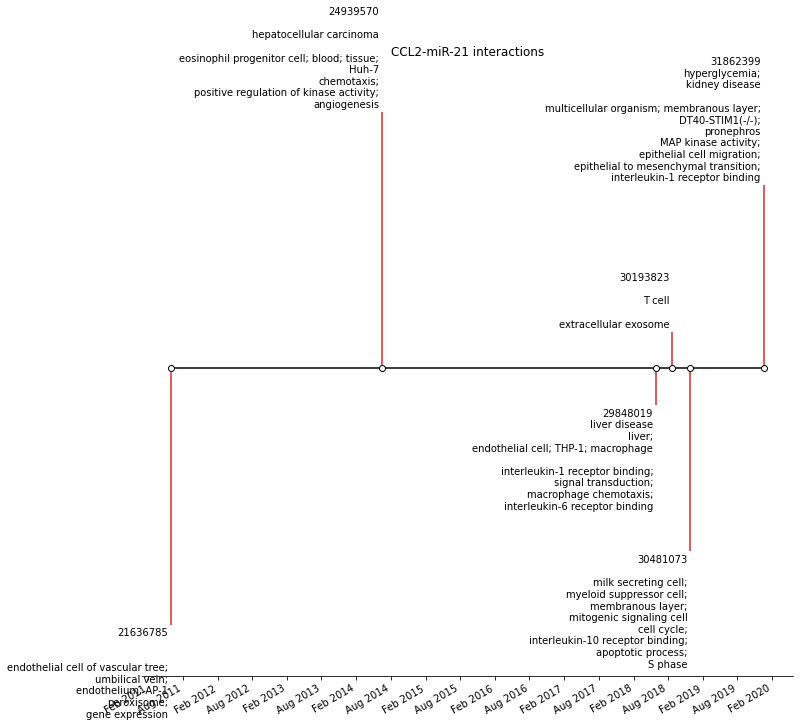

In [27]:
make_timeline(int2pubdate[('CCL2', 'miR-21')], "CCL2-miR-21 interactions") 